# Spotify Premium Prediction

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
# Load the datasets
file_path = "Spotify_data.xlsx"
file_path2 = "Spotify_data2.xlsx"
df1 = pd.read_excel(file_path)
df2 = pd.read_excel(file_path2)

# Combine the datasets
combined_df = pd.concat([df1, df2], ignore_index=True)

# Display
combined_df.head()

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,None,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,None,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,None,Music,Melody,Night,"Relaxation and stress relief, Social gathering...","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,None,None,None,None,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,None,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok


In [3]:
combined_df.shape

(600, 20)

## Persona Construction

In [4]:
# Define personas
premium_members = combined_df[combined_df['spotify_subscription_plan'] == 'Premium (paid subscription)']
free_members = combined_df[combined_df['spotify_subscription_plan'] == 'Free (ad-supported)']
free_members_willing_to_upgrade = combined_df[(combined_df['spotify_subscription_plan'] == 'Free (ad-supported)') & 
                                              (combined_df['premium_sub_willingness'] == 'Yes')]

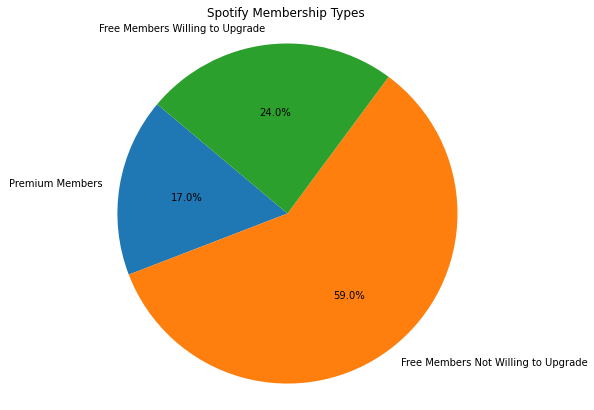

In [5]:
# Plotting the pie chart
sizes = [len(premium_members), len(free_members) - len(free_members_willing_to_upgrade), len(free_members_willing_to_upgrade)]
labels = ['Premium Members', 'Free Members Not Willing to Upgrade', 'Free Members Willing to Upgrade']

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Spotify Membership Types')
plt.show()

In [6]:
# Initialize a dictionary to hold the modes
premium_modes = {}

# Iterate through each column to calculate the mode
for column in premium_members.columns:
    if premium_members[column].dtype == 'object' or len(premium_members[column].unique()) < 10:
        mode_value = stats.mode(premium_members[column])[0][0]
        premium_modes[column] = mode_value

In [7]:
premium_modes

{'Age': '20-35',
 'Gender': 'Female',
 'spotify_usage_period': '1 year to 2 years',
 'spotify_listening_device': 'Smartphone',
 'spotify_subscription_plan': 'Premium (paid subscription)',
 'premium_sub_willingness': 'Yes',
 'preffered_premium_plan': 'Individual Plan- Rs 119/ month',
 'preferred_listening_content': 'Music',
 'fav_music_genre': 'Melody',
 'music_time_slot': 'Night',
 'music_Influencial_mood': 'Relaxation and stress relief',
 'music_lis_frequency': 'While Traveling',
 'music_expl_method': 'Radio',
 'music_recc_rating': 3,
 'pod_lis_frequency': 'Rarely',
 'fav_pod_genre': 'Health and Fitness',
 'preffered_pod_format': 'Story telling',
 'pod_host_preference': 'Both',
 'preffered_pod_duration': 'Longer',
 'pod_variety_satisfaction': 'Ok'}

In [8]:
# Initialize a dictionary to hold the modes
free_modes = {}

# Iterate through each column to calculate the mode
for column in free_members.columns:
    if free_members[column].dtype == 'object' or len(free_members[column].unique()) < 10:
        mode_value = stats.mode(free_members[column])[0][0]
        free_modes[column] = mode_value

In [9]:
free_modes

{'Age': '20-35',
 'Gender': 'Female',
 'spotify_usage_period': 'More than 2 years',
 'spotify_listening_device': 'Smartphone',
 'spotify_subscription_plan': 'Free (ad-supported)',
 'premium_sub_willingness': 'No',
 'preffered_premium_plan': 'None',
 'preferred_listening_content': 'Music',
 'fav_music_genre': 'Melody',
 'music_time_slot': 'Night',
 'music_Influencial_mood': 'Relaxation and stress relief',
 'music_lis_frequency': 'leisure time',
 'music_expl_method': 'Playlists',
 'music_recc_rating': 4,
 'pod_lis_frequency': 'Rarely',
 'fav_pod_genre': 'None',
 'preffered_pod_format': 'None',
 'pod_host_preference': 'Both',
 'preffered_pod_duration': 'Shorter',
 'pod_variety_satisfaction': 'Ok'}

In [10]:
# Initialize a dictionary to hold the modes
upgrade_modes = {}

# Iterate through each column to calculate the mode
for column in free_members_willing_to_upgrade.columns:
    mode_series = free_members_willing_to_upgrade[column].mode()
    if not mode_series.empty:  # Check if the mode could be computed
        upgrade_modes[column] = mode_series[0]

In [11]:
upgrade_modes

{'Age': '20-35',
 'Gender': 'Female',
 'spotify_usage_period': 'More than 2 years',
 'spotify_listening_device': 'Smartphone',
 'spotify_subscription_plan': 'Free (ad-supported)',
 'premium_sub_willingness': 'Yes',
 'preffered_premium_plan': 'Individual Plan- Rs 119/ month',
 'preferred_listening_content': 'Music',
 'fav_music_genre': 'Melody',
 'music_time_slot': 'Night',
 'music_Influencial_mood': 'Relaxation and stress relief',
 'music_lis_frequency': 'While Traveling',
 'music_expl_method': 'recommendations, Playlists',
 'music_recc_rating': 3,
 'pod_lis_frequency': 'Rarely',
 'fav_pod_genre': 'Lifestyle and Health',
 'preffered_pod_format': 'Story telling',
 'pod_host_preference': 'Both',
 'preffered_pod_duration': 'Shorter',
 'pod_variety_satisfaction': 'Ok'}

## Variable Convertion

#### Converting categorical variables into numerical

In [12]:
# check data types
combined_df.dtypes

Age                            object
Gender                         object
spotify_usage_period           object
spotify_listening_device       object
spotify_subscription_plan      object
premium_sub_willingness        object
preffered_premium_plan         object
preferred_listening_content    object
fav_music_genre                object
music_time_slot                object
music_Influencial_mood         object
music_lis_frequency            object
music_expl_method              object
music_recc_rating               int64
pod_lis_frequency              object
fav_pod_genre                  object
preffered_pod_format           object
pod_host_preference            object
preffered_pod_duration         object
pod_variety_satisfaction       object
dtype: object

In [13]:
le=LabelEncoder()

# Encode categorical features using LabelEncoder
lst=['Age','Gender','spotify_usage_period','spotify_listening_device','spotify_subscription_plan',
     'premium_sub_willingness','preffered_premium_plan','preferred_listening_content','fav_music_genre',
     'music_time_slot','music_Influencial_mood','music_lis_frequency','music_expl_method','pod_lis_frequency',
     'fav_pod_genre','preffered_pod_format','pod_host_preference','preffered_pod_duration',
     'pod_variety_satisfaction']
for i in lst:
    combined_df[i]=le.fit_transform(combined_df[i])

In [14]:
# Show results
combined_df

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,1,0,3,4,0,1,1,1,4,3,8,34,4,3,0,1,2,0,0,1
1,0,1,3,0,0,1,2,1,7,0,10,32,4,2,4,1,2,0,2,2
2,2,2,1,4,0,1,4,1,6,3,0,19,4,4,2,17,2,1,0,2
3,1,0,0,11,0,0,3,0,4,3,3,13,13,4,1,12,3,1,2,1
4,1,0,0,6,0,0,3,0,4,3,0,34,13,4,3,10,4,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,1,0,0,0,1,2,1,5,2,15,19,13,5,4,20,5,4,3,1
596,0,2,3,4,0,0,3,1,7,2,15,13,13,5,1,20,5,4,0,2
597,0,0,2,0,0,0,3,1,9,1,15,34,13,5,0,20,5,4,3,1
598,0,0,3,6,0,1,2,0,6,1,15,34,13,3,0,20,5,4,3,0


In [15]:
# Separate `X` and target variable `y` from `combined_df`
X=combined_df.drop(['premium_sub_willingness'],axis=1)
y_new=combined_df['premium_sub_willingness']   

## Feature Seleciton

### HeatMap

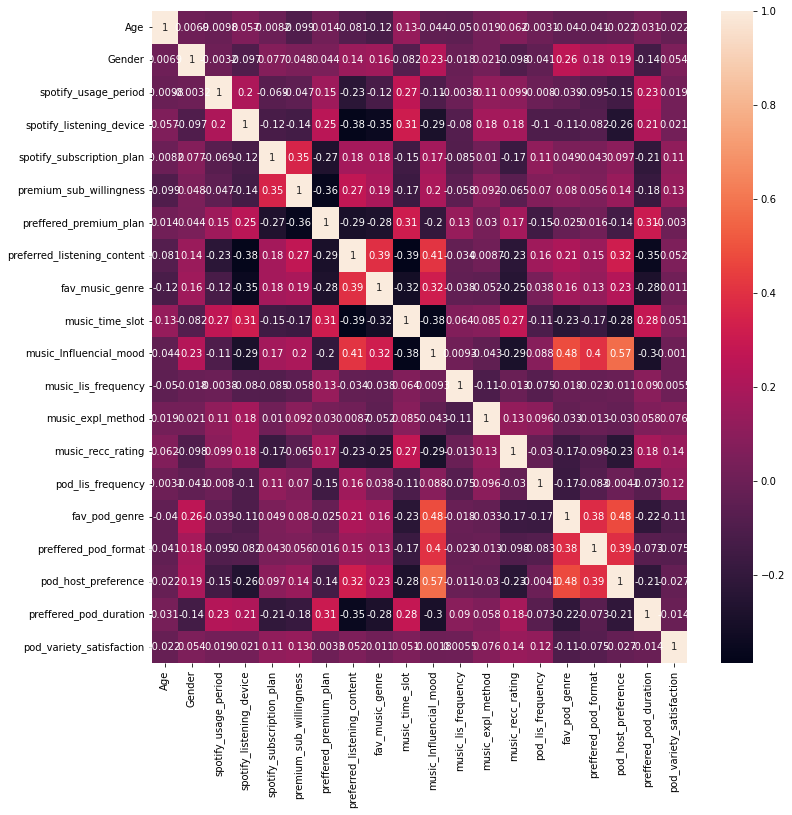

In [16]:
# Create heatmap of the correlation matrix
try:
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    sns.heatmap(combined_df.corr(), annot=True, ax=ax)
    plt.show()  
    
# If an error occurs, it prints the error message
except Exception as e:
    print("An error occurred:", e)


* spotify_listening_device seems to have a few moderately high correlations with other features.
* music_time_slot and music_influencial_mood show some degree of correlation with each other.
* fav_music_genre and fav_pod_genre also appear to have some correlation with other features.
* preferred_pod_format and pod_host_preference exhibit some correlation with other features as well.

preferred_premium_plan and preferred_listening_content seems to have high correlation with Y variable.

In [17]:
# Drop features that are highly overlapped based on the heatmap
features_to_drop = ['spotify_listening_device', 'music_time_slot','preffered_pod_duration', 
                    'fav_music_genre', 'music_Influencial_mood', 'pod_host_preference', 'preffered_pod_format']

In [18]:
# Show new dataframe columns after heatmap feature selection
X_new_1=X.drop(features_to_drop,axis=1)
X_new_1.columns

Index(['Age', 'Gender', 'spotify_usage_period', 'spotify_subscription_plan',
       'preffered_premium_plan', 'preferred_listening_content',
       'music_lis_frequency', 'music_expl_method', 'music_recc_rating',
       'pod_lis_frequency', 'fav_pod_genre', 'pod_variety_satisfaction'],
      dtype='object')

### Chi-Square feature selection

In [19]:
# Initialize `SelectKBest' and fit
selector = SelectKBest(score_func=chi2, k=8)
X_new_2 = selector.fit_transform(X_new_1,y_new)

# Retrieve indices of selected features and show
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_new_1.columns[selected_feature_indices]
selected_features

Index(['Age', 'spotify_subscription_plan', 'preffered_premium_plan',
       'preferred_listening_content', 'music_lis_frequency',
       'music_expl_method', 'fav_pod_genre', 'pod_variety_satisfaction'],
      dtype='object')

In [20]:
# Create a new dataframe that contains final features 
X_new_3= X_new_1[selected_features]

### Minmaxscalling

In [21]:
# Scale dataframe using the Minmaxscaler and store the result in `X_new`.
minmax=MinMaxScaler()
X_new=minmax.fit_transform(X_new_3)
X_new

array([[0.25      , 0.        , 0.25      , ..., 0.21052632, 0.05      ,
        0.25      ],
       [0.        , 0.        , 0.5       , ..., 0.21052632, 0.05      ,
        0.5       ],
       [0.5       , 0.        , 1.        , ..., 0.21052632, 0.85      ,
        0.5       ],
       ...,
       [0.        , 0.        , 0.75      , ..., 0.68421053, 1.        ,
        0.25      ],
       [0.        , 0.        , 0.5       , ..., 0.68421053, 1.        ,
        0.        ],
       [0.5       , 0.        , 0.75      , ..., 0.21052632, 1.        ,
        0.25      ]])

## Modeling

In [22]:
# Split training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Initialize a `LogisticRegression` model 
log_reg = LogisticRegression(max_iter=1000)

In [23]:
# Fit the regression model
log_reg.fit(X_train, y_train)
y_pred_1 = log_reg.predict(X_test)

In [24]:
# Get model metrics
accuracy = accuracy_score(y_test, y_pred_1)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred_1)
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(y_test, y_pred_1))

Accuracy: 0.7833333333333333
Confusion Matrix:
 [[67  9]
 [17 27]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        76
           1       0.75      0.61      0.67        44

    accuracy                           0.78       120
   macro avg       0.77      0.75      0.76       120
weighted avg       0.78      0.78      0.78       120



### Hyperparameter Tunning

In [25]:
# Get best model parameter using GridSearchCV
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

In [26]:
# Print best parameter
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [27]:
# Use the best parameter for prediction
logistic_model = grid_search.best_estimator_
y_pred_2 = logistic_model.predict(X_test)

In [28]:
# Print model metrics after hyperparameter tuning
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred_2)
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(y_test, y_pred_2))

Accuracy: 0.7666666666666667
Confusion Matrix:
 [[64 12]
 [16 28]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        76
           1       0.70      0.64      0.67        44

    accuracy                           0.77       120
   macro avg       0.75      0.74      0.74       120
weighted avg       0.76      0.77      0.76       120



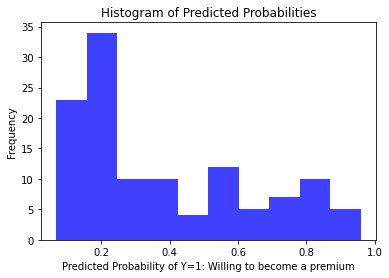

In [29]:
# Get the probability of the positive class
probabilities = logistic_model.predict_proba(X_test)[:, 1]  

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Create a histogram of the predicted probabilities
plt.hist(probabilities, bins=10, alpha=0.75, color='blue')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Y=1: Willing to become a premium')
plt.ylabel('Frequency')
plt.show()


In [30]:
# Print regression intercept
intercept = logistic_model.intercept_[0]
intercept

-0.49070554595778104

In [31]:
# Show the coefficients of each feature in regression formula
coefficients = logistic_model.coef_[0]
df_scaled = pd.DataFrame(X_new, columns=X_new_3.columns)
feature_importance = pd.DataFrame({'Feature': df_scaled.columns, 'Coefficient': coefficients})
feature_importance

,Feature,Coefficient
0,Age,-1.586114
1,spotify_subscription_plan,1.669331
2,preffered_premium_plan,-2.137643
3,preferred_listening_content,0.495493
4,music_lis_frequency,-0.063276
5,music_expl_method,0.780182
6,fav_pod_genre,0.486882
7,pod_variety_satisfaction,1.469716
